# FrozenLake description dataset

In [33]:
import os
import sys

rocket_dir = os.path.split(os.path.abspath(os.curdir))[:-1]
rocket_src_dir = os.path.join(*rocket_dir, 'src')
rocket_dir = os.path.join(*rocket_dir)

print(f'Appending to sys.path:', [rocket_dir, rocket_src_dir])

sys.path.append(rocket_dir)
sys.path.append(rocket_src_dir)

import warnings

warnings.filterwarnings('ignore')

from src.environments.frozen_env import FrozenLakeText
import numpy as np
import torch
from IPython.display import display
from torchvision.transforms import ToPILImage
from PIL import Image
import pygame
import re
import colorama
import enum
from src.environments.utils import VisualObsWrapper
from torchvision.transforms.functional import resize
from itertools import chain
from datasets import Dataset, DatasetDict, concatenate_datasets

Appending to sys.path: ['/home/davide/rocket', '/home/davide/rocket/src']


## Task definition

We define some *description* tasks. These will be used to evaluate how much a Vision Language Model (VLM) understands the FrozenLake reinforcement learning environment.

We choose to differentiate basic tasks and complex tasks.

In [17]:

class BasicTask(enum.Enum):
    describe_tile = enum.auto()
    describe_state = enum.auto()
    get_num_cells = enum.auto()
    describe_each_cell = enum.auto()    


class ComplexTask(enum.Enum):
    find_goal = enum.auto()
    get_expected_actions = enum.auto()
    is_player_dead = enum.auto()
    get_safe_actions = enum.auto()
    get_num_holes = enum.auto()
    get_entities_in_fov = enum.auto()
    get_last_action = enum.auto()

The following function maps each task to the instruction that the LLM gets to solve it.

In [18]:
def task2instruction(task):
    # Basic tasks
    if task == BasicTask.describe_tile:
        return 'Describe the tile you see in the image'
    elif task == BasicTask.describe_state:
        return 'Describe the state of the environment from the player\'s perspective'
    elif task == BasicTask.get_num_cells:
        return 'How many cells are there in the environment?'
    elif task == BasicTask.describe_each_cell:
        return 'Describe each cell of the environment from left to right, bottom to top. Use the format: "The cell [<x>, <y>] contains <tile_content>. Bottom left cell is [0, 0]'
    
    # Complex tasks
    elif task == ComplexTask.find_goal:
        return 'Write the direction and the distance (in steps) from the player to the goal'
    elif task == ComplexTask.get_expected_actions:
        return 'Write the expected actions of the player to reach the goal safely'
    elif task == ComplexTask.is_player_dead:
        return 'Is the player dead?'
    elif task == ComplexTask.get_safe_actions:
        return 'Write the list of actions that are safe for the player to execute'
    elif task == ComplexTask.get_num_holes:
        return 'How many holes are there in the environment?'
    elif task == ComplexTask.get_entities_in_fov:
        return 'Write the entities in the player\'s field of view (1 step)'  # TODO: add the number of steps to generalize
    elif task == ComplexTask.get_last_action:
        return 'Write the last action executed by the player'

We want the model to describe game tiles as well (since we are in a grid-like world). We define an enum of tile types.

In [19]:
class Tile(enum.Enum):
    ice = enum.auto()
    hole = enum.auto()
    cracked_hole = enum.auto()
    player_north = enum.auto()
    player_south = enum.auto()
    player_east = enum.auto()
    player_west = enum.auto()
    goal = enum.auto()
    start = enum.auto()

And the mapping tile to tile-name.

In [20]:
def tile2name(tile):
    if tile == Tile.ice:
        return 'an ice cell'
    elif tile == Tile.hole:
        return 'a hole'
    elif tile == Tile.cracked_hole:
        return 'a cracked hole'
    elif tile == Tile.player_north:
        return 'the player (facing north)'
    elif tile == Tile.player_south:
        return 'the player (facing south)'
    elif tile == Tile.player_east:
        return 'the player (facing east)'
    elif tile == Tile.player_west:
        return 'the player (facing west)'
    elif tile == Tile.goal:
        return 'the goal'
    elif tile == Tile.start:
        return 'the start cell'

## Modified env definition

Now we define a modified version of the FrozenLakeText environment (our variant with text description) that enables us to sample plausible game states, get diverse description, etc. All these features are NOT part of the game itself, they are useful only for the purpose of generating game description to train the LLM on.

In [21]:
class ModifiedFrozenLakeText(FrozenLakeText):
    def _text2direction(self, text):
        direction = re.sub(r'.*(?P<direction>north|south|east|west).*', r'\g<direction>', text)
        return direction

    def set_random_position_and_direction(self, rnd_gen=None):
        if rnd_gen is None:
            rnd_gen = np.random.default_rng()
        self.s = rnd_gen.integers(0, self.ncol * self.nrow)
        self.last_action = rnd_gen.integers(0, 4)
        self.lastaction = self.last_action
        
    def get_goal_description(self):
        desc = self._get_entity_desc(self.goal, "the goal").strip()[2:-1]
        desc = desc.replace("goal", "goal is")
        return desc

    def _is_hole(self, pos):
        for hole in self.holes:
            if np.all(pos == hole):
                return True
        return False

    def is_player_dead(self):
        return self._is_hole(self._get_pos(self.s))

    def _neighbor_safe_cells(self, pos):
        neighbors = [
            pos + np.array([0, 1]),
            pos + np.array([0, -1]),
            pos + np.array([1, 0]),
            pos + np.array([-1, 0])
        ]
        neighbors = [n for n in neighbors if not self._is_hole(n) and 0 <= n[0] < self.ncol and 0 <= n[1] < self.nrow]
        return neighbors

    def get_safe_actions(self):
        pos = self._get_pos(self.s)
        neighbors = self._neighbor_safe_cells(pos)
        text_neighbors = [self._get_entity_desc(n, "a cell").strip()[2:-1] for n in neighbors]
        direction_neighbors = [self._text2direction(t) for t in text_neighbors]
        
        mapper = {'north': 'forward', 'south': 'backward', 'east': 'right', 'west': 'left'}
        actions = [mapper[d] for d in direction_neighbors]
        
        return actions

    def get_expected_actions(self):
        # check directions are walkable
        pos = self._get_pos(self.s)
        neighbors = self._neighbor_safe_cells(pos)
        allowed_directions = [self._get_entity_desc(n, "a cell").strip()[2:-1].split(' ')[-1] for n in neighbors]
    
        # check goal direction
        direction = self._get_entity_desc(self.goal, "the goal").strip()[2:-1].split(" ")[-1]
        directions = direction.split('-') if '-' in direction else [direction]    
        directions = [d for d in directions if d in allowed_directions]
        
        mapper = {'north': 'forward', 'south': 'backward', 'east': 'right', 'west': 'left'}
        actions = [mapper[d] for d in directions]
        
        return actions

    def get_last_action(self):
        return self.action2label.get(self.last_action, 'stand still')

    def get_entities_in_fov(self):
        n_walls, n_holes = 0, 0
        for wall_pos in self.walls:
            n_walls += 1 if self._get_entity_desc(wall_pos, "a wall") != '' else 0
        for hole_pos in self.holes:
            n_holes += 1 if self._get_entity_desc(hole_pos, "a hole") != '' else 0
        return f'{n_walls if n_walls else "no"} walls and {n_holes if n_holes else "no"} holes'
    
    def get_state_description(self):
        text_obs = self._get_text_obs().split('I see:')[-1].replace('.', '').strip('\n ')
        text_obs = text_obs.replace('my', 'the player\'s')
        text_obs = ', '.join(e.strip() for e in text_obs.split('- ') if e.strip())
        text_obs = 'The map shows: ' + text_obs
        return text_obs
    
    def get_cell_by_cell_description(self):
        desc = ''
        for y in range(self.nrow):
            for x in range(self.ncol):
                desc += f'The cell [{x}, {y}] contains '
                if self._is_hole(np.array([x, y])):
                    desc += 'a hole'
                elif np.all(self._get_pos(self.s) == np.array([x, y])):
                    desc += 'the player'
                elif x == 0 and y == self.nrow - 1:
                    desc += 'the start cell'
                elif x == self.ncol - 1 and y == 0:
                    desc += 'the goal'
                else:
                    desc += 'ice'
                desc += '\n'
        return desc

Now we can define a mapping function that gets the task and the env (with the respective state) and returns the description, or more precisely the answer to the task question.

More answers could be plausible.

In [22]:
def task2answers(task, env, tile=None):
    # Basic tasks
    if task == BasicTask.describe_tile:
        assert tile is not None, 'Tile must be provided'
        return ['The picture shows ' + tile2name(tile)]
    elif task == BasicTask.describe_state:
        return [env.get_state_description()]
    elif task == BasicTask.get_num_cells:
        return ['The maps has ' + str(env.ncol * env.nrow) + ' cells']
    elif task == BasicTask.describe_each_cell:
        return [env.get_cell_by_cell_description()]
    
    # Complex tasks
    elif task == ComplexTask.find_goal:
        return ['Based on the picture of the state above, it seems that ' + env.get_goal_description()]
    elif task == ComplexTask.get_expected_actions:
        return [f'Based on the picture of the state above, it seems that the player should move {action} to reach the goal safely' for action in env.get_expected_actions()]
    elif task == ComplexTask.is_player_dead:
        return ['Based on the picture of the state above, it seems that the player ' + ('is dead because he fell into a hole' if env.is_player_dead() else 'is alive')]
    elif task == ComplexTask.get_safe_actions:
        return [f'Based on the picture of the state above, it seems that the player can move {action} without dying' for action in env.get_safe_actions()]
    elif task == ComplexTask.get_num_holes:
        return ['The maps has ' + str(len(env.holes)) + ' holes']
    elif task == ComplexTask.get_entities_in_fov:
        return [f'The player can see {env.get_entities_in_fov()} {env.fov} step{"s" if env.fov > 1 else ""} away from him']
    elif task == ComplexTask.get_last_action:
        return ['The last action executed by the player was to ' + env.get_last_action()]

We define the function to generate environments, and a utility function to convert pygame surfaces to PIL images.

In [23]:
def make_modified_frozen_env(
    area=8, # 8x8
    size=(244, 244),
    seed=None,
):   
    def resize_obs(obs):
        obs = torch.from_numpy(obs).permute(2, 0, 1)
        obs = resize(obs, size, antialias=False)
        obs = obs.permute(1, 2, 0).numpy()
        return obs
    
    frozen_env = ModifiedFrozenLakeText(map_size=area, is_slippery=False, seed=seed, fov=1, fixed_orientation=True, first_person=True)
    frozen_env = VisualObsWrapper(frozen_env, transform=resize_obs)
    return frozen_env


def pygame_surface2pil_image(surface): 
    image_str = pygame.image.tostring(surface, 'RGBA')
    return Image.frombytes('RGBA', surface.get_size(), image_str)

## Dataset generation

We are finally ready to define the function to generate the dataset.

The function samples a number of states randomly (with the game area sampled from a given range). For each state, a set of questions and answers is generated. Finally, the description of the tiles is added.

In [24]:
def generate_dataset(*, num_states, seed, area_range=(2, 12)):
    to_pil = ToPILImage()   
    rnd_gen = np.random.default_rng(seed)
    
    dataset = []

    # add random states tasks
    for _ in range(num_states):
        area_size = rnd_gen.integers(*area_range)
        env_seed = int(rnd_gen.integers(0, 1_000_000_000))
        env = make_modified_frozen_env(seed=env_seed, area=area_size)
        env.reset(seed=env_seed)
        
        # sample random position and set it
        env.set_random_position_and_direction(rnd_gen)
        
        visual_obs = to_pil(env.render())
        
        # Basic tasks
        for task in BasicTask:
            if task != BasicTask.describe_tile:
                answer = task2answers(task, env)
                for ans in answer:
                    dataset.append({
                        'id': len(dataset),
                        'task': task.name,
                        'env_seed': env_seed,
                        'image': visual_obs,
                        'instruction': task2instruction(task),
                        'answer': ans
                    })
        
        # Complex tasks
        for task in ComplexTask:
            answer = task2answers(task, env)
            for ans in answer:
                dataset.append({
                    'id': len(dataset),
                    'task': task.name,
                    'enc_seed': None,
                    'image': visual_obs,
                    'instruction': task2instruction(task),
                    'answer': ans
                })
                
    # add tile description task
    tile2pygame_surface = {
        Tile.ice: env.ice_img,
        Tile.hole: env.hole_img,
        Tile.cracked_hole: env.cracked_hole_img,
        Tile.player_north: env.elf_images[0],
        Tile.player_south: env.elf_images[1],
        Tile.player_east: env.elf_images[2],
        Tile.player_west: env.elf_images[3],
        Tile.goal: env.goal_img,
        Tile.start: env.start_img
    }
    tiles_with_ice_background = [Tile.player_north, Tile.player_south, Tile.player_east, Tile.player_west, Tile.goal, Tile.start]

    for tile in Tile:
        image = pygame_surface2pil_image(tile2pygame_surface[tile])
        if tile in tiles_with_ice_background:
            background = pygame_surface2pil_image(tile2pygame_surface[Tile.ice])
            background.paste(image, (0, 0), image)
            image = background
            
        # remove alpha channel from PIL image
        
            
        dataset.append({
            'task': BasicTask.describe_tile.name,
            'image': image.convert('RGB'),
            'instruction': task2instruction(BasicTask.describe_tile),
            'answer': task2answers(BasicTask.describe_tile, env, tile=tile)[0]
        })    
               
    return dataset

We generate a dataset of ~2300 examples.

In [25]:
dataset = generate_dataset(num_states=200, seed=42)

len(dataset)

2398

Let's see some examples.

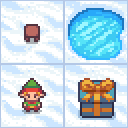

TASK:
get_last_action

INSTRUCTION:
Write the last action executed by the player

ANSWER:
The last action executed by the player was to move south


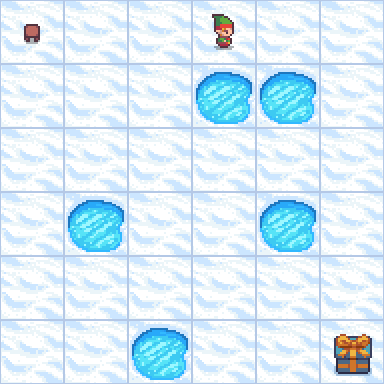

TASK:
describe_state

INSTRUCTION:
Describe the state of the environment from the player's perspective

ANSWER:
The map shows: a wall 1 steps to the player's north, a trap 1 steps to the player's south, the goal 7 steps to the player's south-east


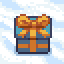

TASK:
describe_tile

INSTRUCTION:
Describe the tile you see in the image

ANSWER:
The picture shows the goal


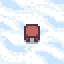

TASK:
describe_tile

INSTRUCTION:
Describe the tile you see in the image

ANSWER:
The picture shows the start cell


In [26]:
for data in chain(dataset[10:12], dataset[-2:]):
    display(data['image'])
    print('TASK:')
    print(data['task'])
    print('\nINSTRUCTION:')
    print(data['instruction'])
    print('\nANSWER:')
    print(data['answer'])
    print(colorama.Fore.GREEN + '=' * 100 + colorama.Style.RESET_ALL)

## Save the dataset with Huggingface `datasets`

Now that we have a well define dataset, we can load it with HuggingFace and push it to the Hub for later use.

In [34]:
random_split_seed = 24

dataset = Dataset.from_list(dataset)

test_size = 100
train_size = len(dataset) - test_size

describe_tile_examples = dataset.filter(lambda x: x['task'] == BasicTask.describe_tile.name)
not_describe_tile_examples = dataset.filter(lambda x: x['task'] != BasicTask.describe_tile.name)

random_shuffle = torch.randperm(len(not_describe_tile_examples))
train_indexes = random_shuffle[:train_size]
test_indexes = random_shuffle[train_size:]

train_dataset = concatenate_datasets([describe_tile_examples, not_describe_tile_examples.select(train_indexes)])
test_dataset = concatenate_datasets([describe_tile_examples, not_describe_tile_examples.select(test_indexes)])

print(f'Train dataset size: {len(train_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

Filter:   0%|          | 0/2398 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2398 [00:00<?, ? examples/s]

Train dataset size: 2307
Test dataset size: 100


In [35]:
datasets = DatasetDict({
    'train': train_dataset,
    'test': test_dataset
})

# dataset.save_to_disk('frozenlake_prompts_dataset')
datasets.push_to_hub('dawoz/frozenlake_prompts_dataset')

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/2307 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/24 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/dawoz/frozenlake_prompts_dataset/commit/7722d05c6ddbcb92a00ca93d37871b9f0fd1008f', commit_message='Upload dataset', commit_description='', oid='7722d05c6ddbcb92a00ca93d37871b9f0fd1008f', pr_url=None, pr_revision=None, pr_num=None)